# 파이썬 머신러닝 완벽 가이드 - 3장

## 1. 정확도

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
titanic_df= pd.read_csv('C:/Users/user/Desktop/학교/학회/21-1/kaggle1/train.csv')

In [3]:
titanic_df.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
# 단순한 classifier 만들어 봄
from sklearn.base import BaseEstimator

class MyDummyClassifier(BaseEstimator):
    def fit(self, X, y=None): # fit() 메서드는 아무것도 학습하지 않음
        pass
    def predict(self, X): # predict() 메서드는 sex 피처가 1이면 0, 아니면 1로 예측함
        pred = np.zeros((X.shape[0], 1))
        for i in range (X.shape[0]):
            if X['Sex'].iloc[i] == 1:# 등호 두개 주의
                pred[i] = 0
            else:
                pred[i] = 1
        return pred
        

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import preprocessing

In [17]:
def fillna(df):
    df['Age'].fillna(df['Age'].mean(), inplace = True)
    df['Cabin'].fillna('N', inplace=True)
    df['Embarked'].fillna('N', inplace=True)
    df['Fare'].fillna(0, inplace=True)
    return df

# 머신러닝 알고리즘에 불필요한 속성 제거
def drop_features(df):
    df.drop(['PassengerId','Name', 'Ticket'], axis=1, inplace= True)
    return df

# 레이블 인코딩 수행
def format_features(df):
    df['Cabin'] = df['Cabin'].str[:1]
    features = ['Cabin', 'Sex', 'Embarked']
    for feature in features:
        le = preprocessing.LabelEncoder() #레이블 인코딩 과정
        le = le.fit(df[feature])
        df[feature] = le.transform(df[feature])
    return df

# 앞에서 설정한 데이터 전처리 함수 호출
def transform_features(df):
    df = fillna(df)
    df = drop_features(df)
    df = format_features(df)
    return df

In [18]:
# 원본 데이터 가공, 학습&테스트 데이터 분할
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1) 
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=0)


titanic_df.drop('Survived', axis=1) ? 

In [19]:
# 위에서 생성한 분류기를 이용해 학습, 예측, 평가 수행
myclf = MyDummyClassifier()
myclf.fit(X_train, y_train)

mypredictions = myclf.predict(X_test)
print("Dummy Classifier의 정확도는: {0:.4f}".format(accuracy_score(y_test, mypredictions)))

Dummy Classifier의 정확도는: 0.7877


단순한 알고리즘으로 예측하더라도 정확도가 높게 나올 수 있음.

-> 정확도는 불균형한 레이블 값 분포에서 적합한 평가 지표가 아님

In [20]:
from sklearn.datasets import load_digits

class MyFakeClassifier(BaseEstimator):
    def fit(self, X, y):
        pass
    #입력 값으로 들어오는 X 데이터 세트의 크기만큼 모두 0으로 만들어서 반환
    def predict(self, X): 
        return np.zeros((len(X), 1), dtype=bool)
    
#mnist 데이터 로딩
digits = load_digits()    

# digits 번호가 7이면 true, astype(int)로 1로 변환, 아니면 False, 0으로 변환
y = (digits.target ==7).astype(int)
X_train, X_test, y_train, y_test = train_test_split(digits.data, y, random_state=11)

In [21]:
# 불균형한 레이블 데이터 분포도 확인
print("레이블 테스트 세트 크기: ", y_test.shape)
print("레이블 세트 레이블 0과 1의 분포도: ")
print(pd.Series(y_test).value_counts())

#myfakeclassifier로 학습, 예측, 정확도 평가
fakeclf = MyFakeClassifier()
fakeclf.fit(X_train, y_train)
fakepred = fakeclf.predict(X_test)
print("모든 예측을 0으로 하여도 정확도는: {:3f}".format(accuracy_score(y_test, fakepred)))

레이블 테스트 세트 크기:  (450,)
레이블 세트 레이블 0과 1의 분포도: 
0    405
1     45
dtype: int64
모든 예측을 0으로 하여도 정확도는: 0.900000


## 2. 오차행렬

In [22]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_test, fakepred)

array([[405,   0],
       [ 45,   0]], dtype=int64)

TN | FP

FN | TP

## 3. 정밀도와 재현율

In [57]:
from sklearn.metrics import precision_score, recall_score #정밀도, 재현율

def get_clf_eval(y_test, pred):# 평가를 한번에 호출하는 함수
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}".
          format(accuracy, precision, recall))

In [24]:
# 로지스틱 회귀 기반으로 타이타닉 생존자 예측하고, 평가를 수행
from sklearn.linear_model import LogisticRegression

# 원본 데이터 가공, 학습&테스트 데이터 분할
titanic_df= pd.read_csv('C:/Users/user/Desktop/학교/학회/21-1/kaggle1/train.csv')
y_titanic_df = titanic_df['Survived']
X_titanic_df = titanic_df.drop('Survived', axis=1) 
X_titanic_df = transform_features(X_titanic_df)
X_train, X_test, y_train, y_test = train_test_split(X_titanic_df, y_titanic_df,
                                                   test_size=0.2, random_state=11)

lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)

get_clf_eval(y_test, pred)

오차행렬
[[104  14]
 [ 13  48]]
정확도: 0.849162, 정밀도: 0.774194, 재현율: 0.786885


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


교재 결과랑 다르게 나옴. 정밀도에 비해 재현율이 낮다고 했는데, 여기선 정밀도가 0.774, 재현율이 0.787로 재현율이 더 높음.

In [25]:
# 개별 데이터별로 예측 확률을 반환하는 메서드 predict_proba()
pred_proba = lr_clf.predict_proba(X_test)
pred = lr_clf.predict(X_test)
print("pred_proba()의 결과 shape: {0} ".format(pred_proba.shape))
print('pred_proba array에서 앞 3개만 샘플로 추출 \n :', pred_proba[:3])

#예측 확률 array와 예측 결과값 array를 병합해 예측확률과 결과값을 한눈에 확인
pred_proba_result = np.concatenate([pred_proba, pred.reshape(-1,1)], axis=1)
print("두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 \n", pred_proba_result[:3])

pred_proba()의 결과 shape: (179, 2) 
pred_proba array에서 앞 3개만 샘플로 추출 
 : [[0.4616653  0.5383347 ]
 [0.87862763 0.12137237]
 [0.87727002 0.12272998]]
두 개의 class 중에서 더 큰 확률을 클래스 값으로 예측 
 [[0.4616653  0.5383347  1.        ]
 [0.87862763 0.12137237 0.        ]
 [0.87727002 0.12272998 0.        ]]


## 4. F1 스코어

## 5. ROC 곡선과 AUC

## 6. 피마 인디언 당뇨병 예측

### 1) import

In [26]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.metrics import f1_score, confusion_matrix, precision_recall_curve, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

In [27]:
diabetes_data = pd.read_csv("C:/Users/user/Desktop/학교/학회/21-1/0322/diabetes.csv")
print(diabetes_data['Outcome'].value_counts())
diabetes_data.head(3)

0    500
1    268
Name: Outcome, dtype: int64


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1


In [28]:
diabetes_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Pregnancies               768 non-null    int64  
 1   Glucose                   768 non-null    int64  
 2   BloodPressure             768 non-null    int64  
 3   SkinThickness             768 non-null    int64  
 4   Insulin                   768 non-null    int64  
 5   BMI                       768 non-null    float64
 6   DiabetesPedigreeFunction  768 non-null    float64
 7   Age                       768 non-null    int64  
 8   Outcome                   768 non-null    int64  
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


null 값 없고, 모두 숫자형

In [29]:
# 피처 데이터 세트 X, 레이블 데이터 세트 y를 추출
X = diabetes_data.iloc[:, :-1] 
y = diabetes_data.iloc[:, -1] #맨 끝이 outcome칼럼으로 레이블 값

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156, stratify=y)

stratify : 지정한 Data의 비율을 유지한다. 

예를 들어, Label Set인 Y가 25%의 0과 75%의 1로 이루어진 Binary Set일 때, stratify=Y로 설정하면 나누어진 데이터셋들도 0과 1을 각각 25%, 75%로 유지한 채 분할된다.

In [50]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [31]:
#로지스틱 회귀로 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,-1]

get_clf_eval(y_test, pred, pred_proba)

오차행렬
[[88 12]
 [23 31]]
정확도: 0.7727, 정밀도: 0.7209, 재현율: 0.5741, F1: 0.6392, AUC: 0.7919


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


정확도가 77.27%, 재현율이 57.41%로 측정됨. 전체 데이터의 64%가 N이므로 재현율 성능에 초점 맞춤

In [42]:
#함수 정의
def precision_recall_curve_plot(y_test, pred_proba_c1):
    precisions, recalls, thresholds = precision_recall_curve(y_test, pred_proba_c1)
    
    plt.figure(figsize=(8,6))
    threshold_boundary = thresholds.shape[0]
    plt.plot(thresholds, precisions[0:threshold_boundary], linestyle='--', label='precision')
    plt.plot(thresholds, recalls[0:threshold_boundary],label='recall')
    
    # threshold값 X축의 scale을 0.1 단위로 변경
    start, end = plt.xlim()
    plt.xticks(np.round(np.arange(start, end, 0.1),2))
    
    # x축, y축 label과 legend, grid 설정
    plt.xlabel('Threshold value'); plt.ylabel("Precision and Recall value")
    plt.legend(); plt.grid()
    plt.show()


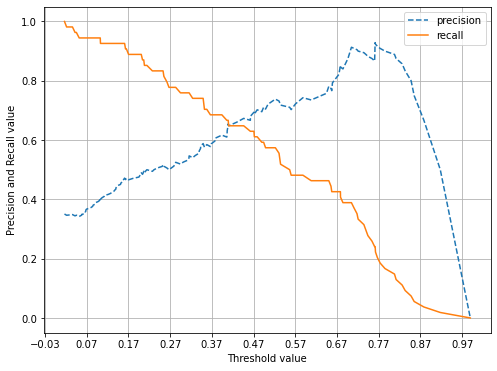

In [41]:
pred_proba_c1 = lr_clf.predict_proba(X_test)[:,1]
precision_recall_curve_plot(y_test, pred_proba_c1)

재현율 곡선을 봤을 때, 임계값을 0.42로 낮추면 정밀도, 재현율이 어느정도 균형. 그러나 두 지표 다 0.7을 넘지 못하는 수치. 데이터 값 점검 필요

In [43]:
diabetes_data.describe()

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
count,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000,768.000000
mean,3.845052,120.894531,69.105469,20.536458,79.799479,31.992578,0.471876,33.240885,0.348958
std,3.369578,31.972618,19.355807,15.952218,115.244002,7.884160,0.331329,11.760232,0.476951
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.078000,21.000000,0.000000
25%,1.000000,99.000000,62.000000,0.000000,0.000000,27.300000,0.243750,24.000000,0.000000
50%,3.000000,117.000000,72.000000,23.000000,30.500000,32.000000,0.372500,29.000000,0.000000
75%,6.000000,140.250000,80.000000,32.000000,127.250000,36.600000,0.626250,41.000000,1.000000
max,17.000000,199.000000,122.000000,99.000000,846.000000,67.100000,2.420000,81.000000,1.000000


min이 0인 피처가 많음. 전체 데이터 건수 대비 몇 퍼센트로 존재하는지 확인 필요.

In [44]:
# 0값 검사할 피처 리스트
zero_features = ['Glucose','BloodPressure', 'SkinThickness', 'Insulin', 'BMI']

# 전체 데이터 건수
total_count = diabetes_data['Glucose'].count()

#피처별로 반복하면서 데이터 값이 0인 데이터 개수 추출, 퍼센트 계산
for feature in zero_features:
    zero_count = diabetes_data[diabetes_data[feature]==0][feature].count()
    print("{0} 0 건수는 {1}, 퍼센트는 {2:.2f}%".format(feature, zero_count, 100*zero_count/total_count))

Glucose 0 건수는 5, 퍼센트는 0.65%
BloodPressure 0 건수는 35, 퍼센트는 4.56%
SkinThickness 0 건수는 227, 퍼센트는 29.56%
Insulin 0 건수는 374, 퍼센트는 48.70%
BMI 0 건수는 11, 퍼센트는 1.43%


In [45]:
#피처의 0 값을 평균값으로 대체
mean_zero_features = diabetes_data[zero_features].mean()
diabetes_data[zero_features] = diabetes_data[zero_features].replace(0, mean_zero_features)

In [46]:
X = diabetes_data.iloc[:, :-1] 
y = diabetes_data.iloc[:, -1] #맨 끝이 outcome칼럼으로 레이블 값

# 피처 스케일링을 적용해 변환
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=156, stratify=y)

In [47]:
# 로지스틱 회귀로 학습, 예측, 평가
lr_clf = LogisticRegression()
lr_clf.fit(X_train, y_train)
pred = lr_clf.predict(X_test)
pred_proba = lr_clf.predict_proba(X_test)[:,1]

get_clf_eval(y_test, pred, pred_proba)


오차행렬
[[90 10]
 [21 33]]
정확도: 0.7987, 정밀도: 0.7674, 재현율: 0.6111, F1: 0.6804, AUC: 0.8433


데이터 변환과 스케일링을 통해 성능 수치가 개선됐음. 재현율 수치는 개선이 필요

임곗값을 변화시키면서 재현율 값의 성능 수치는 어느 정도 개선되는지 확인

In [ ]:
def get_clf_eval(y_test, pred):# 평가를 한번에 호출하는 함수
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:4f}, 정밀도: {1:4f}, 재현율: {2:4f}".
          format(accuracy, precision, recall))

In [58]:
def get_eval_by_threshold(y_test, pred_proba_c1, thresholds):
    for custom_threshold in thresholds:
        binarizer = Binarizer(threshold=custom_threshold).fit(pred_proba_c1)
        custom_predict = binarizer.transform(pred_proba_c1)
        print("임곗값: ", custom_threshold)
        get_clf_eval(y_test, custom_predict)

In [59]:
from sklearn.preprocessing import Binarizer

In [60]:
thresholds = [0.3, 0.33, 0.36, 0.39, 0.42, 0.45, 0.48, 0.50]
pred_proba = lr_clf.predict_proba(X_test)
get_eval_by_threshold(y_test, pred_proba[:,1].reshape(-1,1), thresholds)

임곗값:  0.3
오차행렬
[[67 33]
 [11 43]]
정확도: 0.714286, 정밀도: 0.565789, 재현율: 0.796296
임곗값:  0.33
오차행렬
[[72 28]
 [12 42]]
정확도: 0.740260, 정밀도: 0.600000, 재현율: 0.777778
임곗값:  0.36
오차행렬
[[76 24]
 [15 39]]
정확도: 0.746753, 정밀도: 0.619048, 재현율: 0.722222
임곗값:  0.39
오차행렬
[[78 22]
 [16 38]]
정확도: 0.753247, 정밀도: 0.633333, 재현율: 0.703704
임곗값:  0.42
오차행렬
[[84 16]
 [18 36]]
정확도: 0.779221, 정밀도: 0.692308, 재현율: 0.666667
임곗값:  0.45
오차행렬
[[85 15]
 [18 36]]
정확도: 0.785714, 정밀도: 0.705882, 재현율: 0.666667
임곗값:  0.48
오차행렬
[[88 12]
 [19 35]]
정확도: 0.798701, 정밀도: 0.744681, 재현율: 0.648148
임곗값:  0.5
오차행렬
[[90 10]
 [21 33]]
정확도: 0.798701, 정밀도: 0.767442, 재현율: 0.611111


정확도, 정밀도를 희생하고 재현율을 높이는 데 가장 좋은 임곗값은 0.33. 그러나 정밀도가 매우 저조해짐. 

0.48인 경우 전반적으로 좋음

In [62]:
def get_clf_eval(y_test, pred=None, pred_proba=None):
    confusion = confusion_matrix(y_test, pred)
    accuracy = accuracy_score(y_test, pred)
    precision = precision_score(y_test, pred)
    recall = recall_score(y_test, pred)
    f1 = f1_score(y_test, pred)
    roc_auc = roc_auc_score(y_test, pred_proba)
    print("오차행렬")
    print(confusion)
    print("정확도: {0:.4f}, 정밀도: {1:.4f}, 재현율: {2:.4f}, F1: {3:.4f}, AUC: {4:.4f}".format(accuracy, precision, recall, f1, roc_auc))

In [63]:
# 임곗값을 0.48로 설정한 Binarizer 생성
binarizer = Binarizer(threshold=0.48)

pred_th_048 = binarizer.fit_transform(pred_proba[:,1].reshape(-1,1))
get_clf_eval(y_test, pred_th_048, pred_proba[:,1])

오차행렬
[[88 12]
 [19 35]]
정확도: 0.7987, 정밀도: 0.7447, 재현율: 0.6481, F1: 0.6931, AUC: 0.8433
